In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Models
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

# tsfresh functions
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

In [57]:
# ForecastingModdel class
class ForecastingModel:
    
    """
    Forecasting model, based on tsfresh feature extraction
    """
    
    def __init__(self, model, params):
        
        """
        Args:
            model: model with fit and predict methods
            parameters: None or list        
        """
        
        self.model = model
        self.params = params
        
    def fit(self, y_train, max_timeshift = 10, rolling_direction = 1):
        
        """
        Method to fit model
        Args:
            y (pd.Series): time series to train 
        """
        
        self.y_train = y_train
        
        self.max_timeshift = max_timeshift
        self.rolling_direction = rolling_direction
        
        df_shift, y = make_forecasting_frame(np.append(self.y_train, 0), kind = "price", 
                            max_timeshift = self.max_timeshift, rolling_direction = self.rolling_direction)
        
        self.X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                                        column_value="value", impute_function=impute, show_warnings=False)
        
        self.X_train.dropna(axis = 1, inplace = True)
        
        self.model.fit(self.X_train[: -1: 1], self.y_train[1: : 1])
        
        pass
    
    def predict(self, forecast_horizont):
        
        """
        Predicting values on the next forecast_horizont values
        """
        
        try:
            y_pred = self.model.predict(self.X_train.iloc[-1][None, :])
        
        except:
            
            print("Model is not fitted yet. Call fit method!")
            return None
        
        y_train = np.append(self.y_train, y_pred)
        
        for it in range(1, forecast_horizont):
            
            df_shift, y = make_forecasting_frame(np.append(y_train, 0), kind = "price", 
                            max_timeshift = self.max_timeshift, rolling_direction = self.rolling_direction)
        
            X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                    column_value="value", impute_function=impute, show_warnings=False)
        
            X_train.dropna(axis = 1, inplace = True)
            
            self.model.fit(X_train.iloc[: -1: 1], y_train[1: : 1])
            y_pred = self.model.predict(X_train.iloc[-1][None, :])
            y_train = np.append(y_train, y_pred)
        
        return y_train[self.y_train.shape[0]: : 1]
        

# Loading Data

In [58]:
data = pd.read_csv('international-airline-passengers.csv', usecols=[1])

In [59]:
data.columns = ["value"]
print(data.shape)
data.head(5)

(145, 1)


,value
0,112.0
1,118.0
2,132.0
3,129.0
4,121.0


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 1 columns):
value    144 non-null float64
dtypes: float64(1)
memory usage: 1.2 KB


In [61]:
data.dropna(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 1 columns):
value    144 non-null float64
dtypes: float64(1)
memory usage: 2.2 KB


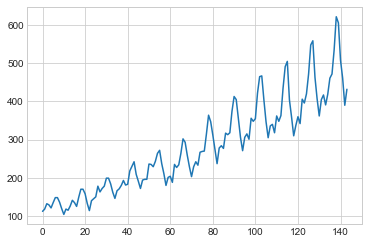

In [62]:
plt.plot(data)
plt.show()

# Train - test - split

In [63]:
alpha = 0.9
N = int(alpha * data.shape[0])
print(N)

129


In [64]:
data_train = data.iloc[:N].copy()
data_test = data.iloc[N:].copy()

data_train.shape, data_test.shape

((129, 1), (15, 1))

# Training

In [87]:
lr = LinearRegression()
ab = AdaBoostRegressor(random_state=123)
cb = CatBoostRegressor(iterations=300)

In [88]:
for_model_cb = ForecastingModel(cb, params=None)
for_model_ab = ForecastingModel(ab, params=None)
for_model_lr = ForecastingModel(lr, params=None)

# catboost

In [89]:
for_model_cb.fit(data_train)

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

0:	learn: 274.1554930	total: 14.6ms	remaining: 4.37s
1:	learn: 267.9576208	total: 28.7ms	remaining: 4.27s
2:	learn: 261.5382488	total: 42.7ms	remaining: 4.23s
3:	learn: 255.0306688	total: 45ms	remaining: 3.33s
4:	learn: 250.0092701	total: 59.2ms	remaining: 3.49s
5:	learn: 245.0176926	total: 73.6ms	remaining: 3.6s
6:	learn: 239.3387345	total: 87.3ms	remaining: 3.65s
7:	learn: 233.5544078	total: 101ms	remaining: 3.69s
8:	learn: 228.2741239	total: 115ms	remaining: 3.72s
9:	learn: 222.6014719	total: 129ms	remaining: 3.73s
10:	learn: 217.2170565	total: 131ms	remaining: 3.45s
11:	learn: 211.8135953	total: 139ms	remaining: 3.35s
12:	learn: 206.7562464	total: 153ms	remaining: 3.38s
13:	learn: 201.6200186	total: 167ms	remaining: 3.41s
14:	learn: 196.8816265	total: 180ms	remaining: 3.43s
15:	learn: 192.5774655	total: 195ms	remaining: 3.46s
16:	learn: 188.0851234	total: 203ms	remaining: 3.38s
17:	learn: 183.4596906	total: 209ms	remaining: 3.28s
18:	learn: 179.1862729	total: 227ms	remaining: 3.35s

166:	learn: 22.5391020	total: 2.98s	remaining: 2.38s
167:	learn: 22.3743946	total: 3s	remaining: 2.36s
168:	learn: 22.2721880	total: 3.03s	remaining: 2.35s
169:	learn: 22.1715936	total: 3.04s	remaining: 2.33s
170:	learn: 21.9388883	total: 3.06s	remaining: 2.31s
171:	learn: 21.6969654	total: 3.07s	remaining: 2.29s
172:	learn: 21.5683251	total: 3.09s	remaining: 2.27s
173:	learn: 21.3950154	total: 3.1s	remaining: 2.25s
174:	learn: 21.3136688	total: 3.11s	remaining: 2.22s
175:	learn: 21.1664855	total: 3.12s	remaining: 2.2s
176:	learn: 21.1152320	total: 3.14s	remaining: 2.18s
177:	learn: 20.9880785	total: 3.15s	remaining: 2.16s
178:	learn: 20.9434809	total: 3.16s	remaining: 2.14s
179:	learn: 20.8615667	total: 3.17s	remaining: 2.12s
180:	learn: 20.6459192	total: 3.19s	remaining: 2.1s
181:	learn: 20.5291032	total: 3.21s	remaining: 2.08s
182:	learn: 20.4398431	total: 3.23s	remaining: 2.06s
183:	learn: 20.3035177	total: 3.24s	remaining: 2.04s
184:	learn: 20.2801690	total: 3.26s	remaining: 2.02s

In [90]:
predictions_cb = for_model_cb.predict(data_test.shape[0])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

0:	learn: 274.5198361	total: 6.32ms	remaining: 1.89s
1:	learn: 268.7516127	total: 23.8ms	remaining: 3.54s
2:	learn: 261.6035840	total: 27.4ms	remaining: 2.72s
3:	learn: 255.4357167	total: 47.4ms	remaining: 3.5s
4:	learn: 249.0390341	total: 69.1ms	remaining: 4.08s
5:	learn: 242.8592610	total: 90.8ms	remaining: 4.45s
6:	learn: 236.9430073	total: 111ms	remaining: 4.63s
7:	learn: 231.0459549	total: 119ms	remaining: 4.35s
8:	learn: 225.3148005	total: 131ms	remaining: 4.23s
9:	learn: 219.9934437	total: 153ms	remaining: 4.43s
10:	learn: 214.4771426	total: 164ms	remaining: 4.32s
11:	learn: 209.4570529	total: 187ms	remaining: 4.49s
12:	learn: 204.4680803	total: 210ms	remaining: 4.63s
13:	learn: 199.8865808	total: 233ms	remaining: 4.75s
14:	learn: 195.3825790	total: 252ms	remaining: 4.78s
15:	learn: 190.7792654	total: 269ms	remaining: 4.77s
16:	learn: 186.0785600	total: 285ms	remaining: 4.74s
17:	learn: 181.9098313	total: 300ms	remaining: 4.71s
18:	learn: 177.6672984	total: 318ms	remaining: 4.71

164:	learn: 22.3408318	total: 2.94s	remaining: 2.41s
165:	learn: 22.2190326	total: 2.97s	remaining: 2.39s
166:	learn: 22.0779049	total: 2.98s	remaining: 2.38s
167:	learn: 22.0032749	total: 3s	remaining: 2.36s
168:	learn: 21.8086749	total: 3.02s	remaining: 2.34s
169:	learn: 21.6868112	total: 3.03s	remaining: 2.32s
170:	learn: 21.6016729	total: 3.06s	remaining: 2.31s
171:	learn: 21.5025086	total: 3.07s	remaining: 2.29s
172:	learn: 21.3044277	total: 3.09s	remaining: 2.27s
173:	learn: 21.1191687	total: 3.1s	remaining: 2.25s
174:	learn: 20.9912248	total: 3.12s	remaining: 2.23s
175:	learn: 20.9136613	total: 3.13s	remaining: 2.21s
176:	learn: 20.7792005	total: 3.15s	remaining: 2.19s
177:	learn: 20.7105215	total: 3.17s	remaining: 2.17s
178:	learn: 20.6320450	total: 3.19s	remaining: 2.16s
179:	learn: 20.4774960	total: 3.22s	remaining: 2.14s
180:	learn: 20.3572938	total: 3.24s	remaining: 2.13s
181:	learn: 20.3087744	total: 3.25s	remaining: 2.11s
182:	learn: 20.2572588	total: 3.28s	remaining: 2.1

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

0:	learn: 275.2962415	total: 11ms	remaining: 3.29s
1:	learn: 268.5492225	total: 26.7ms	remaining: 3.98s
2:	learn: 262.7368924	total: 42.8ms	remaining: 4.23s
3:	learn: 256.3749910	total: 58ms	remaining: 4.29s
4:	learn: 250.3885192	total: 73.5ms	remaining: 4.33s
5:	learn: 244.4820978	total: 88.9ms	remaining: 4.36s
6:	learn: 238.4499527	total: 104ms	remaining: 4.37s
7:	learn: 232.6810880	total: 120ms	remaining: 4.37s
8:	learn: 227.4724485	total: 135ms	remaining: 4.38s
9:	learn: 221.7035294	total: 144ms	remaining: 4.19s
10:	learn: 217.0909907	total: 160ms	remaining: 4.21s
11:	learn: 212.5254226	total: 176ms	remaining: 4.22s
12:	learn: 207.1567616	total: 185ms	remaining: 4.08s
13:	learn: 202.5329899	total: 201ms	remaining: 4.1s
14:	learn: 197.7928663	total: 218ms	remaining: 4.13s
15:	learn: 192.9610384	total: 237ms	remaining: 4.21s
16:	learn: 188.3629591	total: 256ms	remaining: 4.26s
17:	learn: 184.2576881	total: 274ms	remaining: 4.29s
18:	learn: 180.2255216	total: 290ms	remaining: 4.29s
19

157:	learn: 25.3605239	total: 2.72s	remaining: 2.44s
158:	learn: 25.2278543	total: 2.74s	remaining: 2.43s
159:	learn: 25.1128396	total: 2.76s	remaining: 2.42s
160:	learn: 24.9664832	total: 2.78s	remaining: 2.4s
161:	learn: 24.8354041	total: 2.8s	remaining: 2.39s
162:	learn: 24.6921665	total: 2.82s	remaining: 2.37s
163:	learn: 24.6353216	total: 2.83s	remaining: 2.35s
164:	learn: 24.5115757	total: 2.85s	remaining: 2.33s
165:	learn: 24.3774573	total: 2.86s	remaining: 2.31s
166:	learn: 24.3393337	total: 2.88s	remaining: 2.29s
167:	learn: 24.2498670	total: 2.89s	remaining: 2.27s
168:	learn: 24.1826744	total: 2.91s	remaining: 2.25s
169:	learn: 24.0454844	total: 2.92s	remaining: 2.23s
170:	learn: 23.9940558	total: 2.95s	remaining: 2.22s
171:	learn: 23.8056273	total: 2.97s	remaining: 2.21s
172:	learn: 23.6775147	total: 2.99s	remaining: 2.19s
173:	learn: 23.5215956	total: 3.01s	remaining: 2.18s
174:	learn: 23.4027053	total: 3.03s	remaining: 2.17s
175:	learn: 23.3557103	total: 3.04s	remaining: 2

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

0:	learn: 275.5303797	total: 19.1ms	remaining: 5.71s
1:	learn: 268.5378764	total: 36.5ms	remaining: 5.44s
2:	learn: 261.9066110	total: 52.6ms	remaining: 5.21s
3:	learn: 255.8513887	total: 68.5ms	remaining: 5.07s
4:	learn: 249.3525311	total: 84.5ms	remaining: 4.99s
5:	learn: 243.0800719	total: 90.8ms	remaining: 4.45s
6:	learn: 237.6194345	total: 106ms	remaining: 4.46s
7:	learn: 232.7235522	total: 122ms	remaining: 4.46s
8:	learn: 227.5918786	total: 138ms	remaining: 4.46s
9:	learn: 222.3842885	total: 154ms	remaining: 4.46s
10:	learn: 216.9828869	total: 170ms	remaining: 4.47s
11:	learn: 211.7437080	total: 188ms	remaining: 4.52s
12:	learn: 206.9503696	total: 209ms	remaining: 4.62s
13:	learn: 202.5840105	total: 231ms	remaining: 4.71s
14:	learn: 197.2606328	total: 237ms	remaining: 4.51s
15:	learn: 192.7825049	total: 257ms	remaining: 4.56s
16:	learn: 187.7963842	total: 275ms	remaining: 4.58s
17:	learn: 183.3645463	total: 293ms	remaining: 4.59s
18:	learn: 178.7436697	total: 306ms	remaining: 4.5

157:	learn: 23.7896970	total: 2.91s	remaining: 2.62s
158:	learn: 23.6088149	total: 2.93s	remaining: 2.6s
159:	learn: 23.4935385	total: 2.95s	remaining: 2.58s
160:	learn: 23.3793977	total: 2.97s	remaining: 2.56s
161:	learn: 23.2162965	total: 2.98s	remaining: 2.54s
162:	learn: 23.0384444	total: 3s	remaining: 2.53s
163:	learn: 22.8959009	total: 3.02s	remaining: 2.51s
164:	learn: 22.7532794	total: 3.04s	remaining: 2.49s
165:	learn: 22.6110849	total: 3.06s	remaining: 2.47s
166:	learn: 22.5003857	total: 3.07s	remaining: 2.45s
167:	learn: 22.2921315	total: 3.09s	remaining: 2.43s
168:	learn: 22.1836871	total: 3.11s	remaining: 2.41s
169:	learn: 22.0973438	total: 3.12s	remaining: 2.39s
170:	learn: 21.9674530	total: 3.14s	remaining: 2.37s
171:	learn: 21.8178555	total: 3.16s	remaining: 2.35s
172:	learn: 21.6068215	total: 3.18s	remaining: 2.33s
173:	learn: 21.4879245	total: 3.19s	remaining: 2.31s
174:	learn: 21.3484789	total: 3.21s	remaining: 2.29s
175:	learn: 21.2465818	total: 3.22s	remaining: 2.2

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

0:	learn: 275.9613613	total: 24.2ms	remaining: 7.24s
1:	learn: 268.9710381	total: 42.3ms	remaining: 6.3s
2:	learn: 262.2045663	total: 61.1ms	remaining: 6.04s
3:	learn: 255.9435987	total: 78.3ms	remaining: 5.79s
4:	learn: 250.4966709	total: 95.2ms	remaining: 5.62s
5:	learn: 244.5541454	total: 112ms	remaining: 5.46s
6:	learn: 239.1121669	total: 128ms	remaining: 5.34s
7:	learn: 233.6073041	total: 144ms	remaining: 5.27s
8:	learn: 228.2032520	total: 162ms	remaining: 5.24s
9:	learn: 223.0653608	total: 179ms	remaining: 5.2s
10:	learn: 217.4745516	total: 196ms	remaining: 5.16s
11:	learn: 212.3184745	total: 213ms	remaining: 5.12s
12:	learn: 207.1907729	total: 232ms	remaining: 5.12s
13:	learn: 202.5143212	total: 252ms	remaining: 5.14s
14:	learn: 197.6292632	total: 271ms	remaining: 5.15s
15:	learn: 192.9531461	total: 289ms	remaining: 5.14s
16:	learn: 188.6892486	total: 307ms	remaining: 5.12s
17:	learn: 184.2855143	total: 327ms	remaining: 5.13s
18:	learn: 180.0619092	total: 351ms	remaining: 5.2s
1

170:	learn: 24.1731432	total: 3.18s	remaining: 2.4s
171:	learn: 24.1185800	total: 3.2s	remaining: 2.38s
172:	learn: 24.0491495	total: 3.2s	remaining: 2.35s
173:	learn: 23.9773489	total: 3.21s	remaining: 2.33s
174:	learn: 23.9055126	total: 3.23s	remaining: 2.31s
175:	learn: 23.8332756	total: 3.25s	remaining: 2.29s
176:	learn: 23.7606651	total: 3.26s	remaining: 2.27s
177:	learn: 23.6797266	total: 3.28s	remaining: 2.25s
178:	learn: 23.5955208	total: 3.3s	remaining: 2.23s
179:	learn: 23.4443546	total: 3.32s	remaining: 2.21s
180:	learn: 23.2419843	total: 3.34s	remaining: 2.2s
181:	learn: 23.1091892	total: 3.37s	remaining: 2.18s
182:	learn: 22.9860592	total: 3.4s	remaining: 2.17s
183:	learn: 22.8253447	total: 3.42s	remaining: 2.16s
184:	learn: 22.6690459	total: 3.44s	remaining: 2.14s
185:	learn: 22.6091417	total: 3.47s	remaining: 2.13s
186:	learn: 22.4016634	total: 3.49s	remaining: 2.11s
187:	learn: 22.3332436	total: 3.51s	remaining: 2.09s
188:	learn: 22.2717080	total: 3.52s	remaining: 2.07s

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

0:	learn: 276.3346331	total: 12ms	remaining: 3.58s
1:	learn: 269.8976854	total: 30.6ms	remaining: 4.57s
2:	learn: 263.5591336	total: 47.8ms	remaining: 4.73s
3:	learn: 257.9648344	total: 64.7ms	remaining: 4.79s
4:	learn: 251.5822594	total: 81.3ms	remaining: 4.8s
5:	learn: 245.8374906	total: 99.2ms	remaining: 4.86s
6:	learn: 240.0499245	total: 120ms	remaining: 5.02s
7:	learn: 234.3652582	total: 137ms	remaining: 5s
8:	learn: 228.7878838	total: 156ms	remaining: 5.05s
9:	learn: 223.2418815	total: 175ms	remaining: 5.06s
10:	learn: 217.8791168	total: 192ms	remaining: 5.04s
11:	learn: 212.5383036	total: 198ms	remaining: 4.76s
12:	learn: 207.3801490	total: 218ms	remaining: 4.81s
13:	learn: 202.6532932	total: 239ms	remaining: 4.89s
14:	learn: 197.8134087	total: 256ms	remaining: 4.87s
15:	learn: 193.4513885	total: 272ms	remaining: 4.83s
16:	learn: 188.7802537	total: 288ms	remaining: 4.8s
17:	learn: 184.3822159	total: 306ms	remaining: 4.79s
18:	learn: 180.4529909	total: 326ms	remaining: 4.81s
19:	

157:	learn: 24.8431107	total: 2.75s	remaining: 2.47s
158:	learn: 24.7726742	total: 2.77s	remaining: 2.46s
159:	learn: 24.6183008	total: 2.79s	remaining: 2.44s
160:	learn: 24.4527478	total: 2.81s	remaining: 2.43s
161:	learn: 24.3750167	total: 2.83s	remaining: 2.41s
162:	learn: 24.2968015	total: 2.85s	remaining: 2.4s
163:	learn: 24.1197615	total: 2.87s	remaining: 2.38s
164:	learn: 23.9999898	total: 2.89s	remaining: 2.36s
165:	learn: 23.8070823	total: 2.9s	remaining: 2.34s
166:	learn: 23.7752990	total: 2.92s	remaining: 2.33s
167:	learn: 23.5704792	total: 2.94s	remaining: 2.31s
168:	learn: 23.5488851	total: 2.94s	remaining: 2.28s
169:	learn: 23.4605914	total: 2.96s	remaining: 2.27s
170:	learn: 23.3900620	total: 2.98s	remaining: 2.25s
171:	learn: 23.2625918	total: 3s	remaining: 2.23s
172:	learn: 23.0387404	total: 3.02s	remaining: 2.22s
173:	learn: 22.8819775	total: 3.04s	remaining: 2.2s
174:	learn: 22.7056252	total: 3.07s	remaining: 2.19s
175:	learn: 22.5797500	total: 3.1s	remaining: 2.18s


/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

0:	learn: 276.3972901	total: 9.93ms	remaining: 2.97s
1:	learn: 269.5741426	total: 29.8ms	remaining: 4.43s
2:	learn: 263.2122365	total: 48.8ms	remaining: 4.83s
3:	learn: 256.9199382	total: 68.4ms	remaining: 5.07s
4:	learn: 250.4809264	total: 86.2ms	remaining: 5.08s
5:	learn: 244.5905661	total: 102ms	remaining: 5.01s
6:	learn: 238.3788149	total: 118ms	remaining: 4.96s
7:	learn: 232.5632563	total: 135ms	remaining: 4.91s
8:	learn: 226.6338893	total: 150ms	remaining: 4.86s
9:	learn: 221.4741439	total: 166ms	remaining: 4.83s
10:	learn: 216.4416786	total: 182ms	remaining: 4.79s
11:	learn: 211.9556549	total: 200ms	remaining: 4.8s
12:	learn: 206.5068269	total: 221ms	remaining: 4.88s
13:	learn: 201.7628587	total: 242ms	remaining: 4.94s
14:	learn: 197.2321415	total: 262ms	remaining: 4.97s
15:	learn: 192.9004552	total: 280ms	remaining: 4.97s
16:	learn: 188.5671917	total: 300ms	remaining: 4.99s
17:	learn: 184.4994573	total: 328ms	remaining: 5.13s
18:	learn: 180.3389100	total: 353ms	remaining: 5.23s

157:	learn: 25.2609291	total: 2.94s	remaining: 2.65s
158:	learn: 25.0927893	total: 2.96s	remaining: 2.63s
159:	learn: 24.8941860	total: 2.98s	remaining: 2.61s
160:	learn: 24.7287930	total: 3s	remaining: 2.59s
161:	learn: 24.6025287	total: 3.03s	remaining: 2.58s
162:	learn: 24.3802318	total: 3.06s	remaining: 2.57s
163:	learn: 24.2663378	total: 3.08s	remaining: 2.55s
164:	learn: 24.1299797	total: 3.1s	remaining: 2.54s
165:	learn: 24.1025399	total: 3.12s	remaining: 2.51s
166:	learn: 23.9988408	total: 3.13s	remaining: 2.49s
167:	learn: 23.8705866	total: 3.15s	remaining: 2.48s
168:	learn: 23.7806421	total: 3.17s	remaining: 2.46s
169:	learn: 23.7218143	total: 3.19s	remaining: 2.44s
170:	learn: 23.4882732	total: 3.21s	remaining: 2.42s
171:	learn: 23.3964164	total: 3.23s	remaining: 2.4s
172:	learn: 23.2375270	total: 3.25s	remaining: 2.38s
173:	learn: 23.2086754	total: 3.26s	remaining: 2.36s
174:	learn: 23.1426994	total: 3.27s	remaining: 2.34s
175:	learn: 22.9055327	total: 3.29s	remaining: 2.32

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

0:	learn: 277.0185244	total: 16.4ms	remaining: 4.91s
1:	learn: 270.0666494	total: 27ms	remaining: 4.03s
2:	learn: 263.5264801	total: 43.5ms	remaining: 4.3s
3:	learn: 257.4189900	total: 59.6ms	remaining: 4.41s
4:	learn: 251.2769957	total: 75.6ms	remaining: 4.46s
5:	learn: 245.5845200	total: 92.3ms	remaining: 4.52s
6:	learn: 239.6507426	total: 108ms	remaining: 4.52s
7:	learn: 234.2759601	total: 124ms	remaining: 4.54s
8:	learn: 228.9284555	total: 142ms	remaining: 4.6s
9:	learn: 223.7691456	total: 158ms	remaining: 4.59s
10:	learn: 218.7326796	total: 174ms	remaining: 4.58s
11:	learn: 213.5028689	total: 191ms	remaining: 4.58s
12:	learn: 207.9854458	total: 208ms	remaining: 4.58s
13:	learn: 203.0059492	total: 232ms	remaining: 4.75s
14:	learn: 198.5012844	total: 254ms	remaining: 4.83s
15:	learn: 193.7103376	total: 274ms	remaining: 4.87s
16:	learn: 188.8719815	total: 293ms	remaining: 4.87s
17:	learn: 184.2112869	total: 310ms	remaining: 4.86s
18:	learn: 179.7982285	total: 329ms	remaining: 4.86s
1

158:	learn: 26.4504504	total: 3.12s	remaining: 2.77s
159:	learn: 26.3416546	total: 3.14s	remaining: 2.75s
160:	learn: 26.2064421	total: 3.16s	remaining: 2.73s
161:	learn: 26.1715632	total: 3.17s	remaining: 2.7s
162:	learn: 25.9816672	total: 3.19s	remaining: 2.68s
163:	learn: 25.8383421	total: 3.2s	remaining: 2.65s
164:	learn: 25.6961386	total: 3.22s	remaining: 2.63s
165:	learn: 25.4816236	total: 3.23s	remaining: 2.61s
166:	learn: 25.2887239	total: 3.25s	remaining: 2.59s
167:	learn: 25.0886278	total: 3.27s	remaining: 2.57s
168:	learn: 24.9978720	total: 3.29s	remaining: 2.55s
169:	learn: 24.9736399	total: 3.32s	remaining: 2.54s
170:	learn: 24.7879108	total: 3.35s	remaining: 2.52s
171:	learn: 24.7360029	total: 3.36s	remaining: 2.5s
172:	learn: 24.6057751	total: 3.38s	remaining: 2.48s
173:	learn: 24.3512448	total: 3.4s	remaining: 2.46s
174:	learn: 24.2185467	total: 3.41s	remaining: 2.44s
175:	learn: 24.0526950	total: 3.42s	remaining: 2.41s
176:	learn: 23.9531940	total: 3.44s	remaining: 2.3

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

0:	learn: 277.3797772	total: 17.3ms	remaining: 5.17s
1:	learn: 271.0630829	total: 34.5ms	remaining: 5.14s
2:	learn: 264.6820544	total: 52.8ms	remaining: 5.22s
3:	learn: 258.2996735	total: 64.3ms	remaining: 4.76s
4:	learn: 251.9820878	total: 81.3ms	remaining: 4.8s
5:	learn: 245.7108397	total: 97.4ms	remaining: 4.77s
6:	learn: 240.4931848	total: 115ms	remaining: 4.8s
7:	learn: 235.1724511	total: 133ms	remaining: 4.84s
8:	learn: 230.3322472	total: 149ms	remaining: 4.83s
9:	learn: 224.5998546	total: 166ms	remaining: 4.81s
10:	learn: 219.0879178	total: 184ms	remaining: 4.83s
11:	learn: 213.6751740	total: 202ms	remaining: 4.86s
12:	learn: 208.2423971	total: 222ms	remaining: 4.9s
13:	learn: 203.0523141	total: 235ms	remaining: 4.8s
14:	learn: 197.8455652	total: 256ms	remaining: 4.86s
15:	learn: 193.7598735	total: 275ms	remaining: 4.88s
16:	learn: 189.0800972	total: 293ms	remaining: 4.88s
17:	learn: 184.7591343	total: 311ms	remaining: 4.87s
18:	learn: 180.2558487	total: 331ms	remaining: 4.89s
1

157:	learn: 25.1665686	total: 2.76s	remaining: 2.48s
158:	learn: 25.0862059	total: 2.78s	remaining: 2.46s
159:	learn: 25.0059914	total: 2.8s	remaining: 2.45s
160:	learn: 24.9067221	total: 2.81s	remaining: 2.43s
161:	learn: 24.7075616	total: 2.83s	remaining: 2.41s
162:	learn: 24.4271922	total: 2.85s	remaining: 2.39s
163:	learn: 24.2708188	total: 2.86s	remaining: 2.37s
164:	learn: 24.1448256	total: 2.88s	remaining: 2.36s
165:	learn: 24.0371304	total: 2.9s	remaining: 2.34s
166:	learn: 23.8853718	total: 2.92s	remaining: 2.32s
167:	learn: 23.7669236	total: 2.93s	remaining: 2.3s
168:	learn: 23.6634866	total: 2.95s	remaining: 2.29s
169:	learn: 23.5543000	total: 2.97s	remaining: 2.27s
170:	learn: 23.4698995	total: 2.99s	remaining: 2.25s
171:	learn: 23.3153845	total: 3.01s	remaining: 2.24s
172:	learn: 23.2331069	total: 3.02s	remaining: 2.22s
173:	learn: 23.1182912	total: 3.04s	remaining: 2.2s
174:	learn: 22.9825900	total: 3.06s	remaining: 2.18s
175:	learn: 22.9328026	total: 3.07s	remaining: 2.1

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

0:	learn: 277.6410078	total: 18.3ms	remaining: 5.46s
1:	learn: 272.0871201	total: 37.5ms	remaining: 5.58s
2:	learn: 265.2484009	total: 55.4ms	remaining: 5.49s
3:	learn: 258.6805174	total: 73.2ms	remaining: 5.42s
4:	learn: 252.4842661	total: 92.2ms	remaining: 5.44s
5:	learn: 246.7761275	total: 110ms	remaining: 5.38s
6:	learn: 240.2022750	total: 129ms	remaining: 5.39s
7:	learn: 234.3794001	total: 149ms	remaining: 5.43s
8:	learn: 228.3953629	total: 169ms	remaining: 5.45s
9:	learn: 222.9515692	total: 188ms	remaining: 5.45s
10:	learn: 217.7448400	total: 208ms	remaining: 5.47s
11:	learn: 212.3571012	total: 231ms	remaining: 5.53s
12:	learn: 207.3139695	total: 255ms	remaining: 5.63s
13:	learn: 201.9489838	total: 268ms	remaining: 5.48s
14:	learn: 197.1848593	total: 286ms	remaining: 5.44s
15:	learn: 192.4402225	total: 309ms	remaining: 5.49s
16:	learn: 188.5662102	total: 335ms	remaining: 5.57s
17:	learn: 183.9466964	total: 360ms	remaining: 5.65s
18:	learn: 179.6285651	total: 384ms	remaining: 5.68

162:	learn: 24.6501184	total: 3.33s	remaining: 2.8s
163:	learn: 24.4850733	total: 3.36s	remaining: 2.79s
164:	learn: 24.3222477	total: 3.39s	remaining: 2.78s
165:	learn: 24.1745824	total: 3.42s	remaining: 2.76s
166:	learn: 24.0968181	total: 3.44s	remaining: 2.74s
167:	learn: 23.9761108	total: 3.46s	remaining: 2.71s
168:	learn: 23.8933483	total: 3.47s	remaining: 2.69s
169:	learn: 23.7917860	total: 3.49s	remaining: 2.67s
170:	learn: 23.6609495	total: 3.5s	remaining: 2.64s
171:	learn: 23.5500609	total: 3.52s	remaining: 2.62s
172:	learn: 23.4421070	total: 3.54s	remaining: 2.6s
173:	learn: 23.3966137	total: 3.56s	remaining: 2.58s
174:	learn: 23.2456808	total: 3.58s	remaining: 2.56s
175:	learn: 23.1478136	total: 3.6s	remaining: 2.53s
176:	learn: 22.9757818	total: 3.61s	remaining: 2.51s
177:	learn: 22.8929022	total: 3.63s	remaining: 2.49s
178:	learn: 22.7368677	total: 3.65s	remaining: 2.47s
179:	learn: 22.6903440	total: 3.67s	remaining: 2.44s
180:	learn: 22.5786063	total: 3.68s	remaining: 2.4

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

0:	learn: 278.4536975	total: 20.2ms	remaining: 6.04s
1:	learn: 271.7034497	total: 37.7ms	remaining: 5.62s
2:	learn: 265.1853777	total: 56.4ms	remaining: 5.58s
3:	learn: 259.2033438	total: 77.8ms	remaining: 5.76s
4:	learn: 253.3657796	total: 102ms	remaining: 6.04s
5:	learn: 247.8581328	total: 126ms	remaining: 6.18s
6:	learn: 241.5949908	total: 147ms	remaining: 6.15s
7:	learn: 235.7917060	total: 168ms	remaining: 6.13s
8:	learn: 230.8469512	total: 192ms	remaining: 6.19s
9:	learn: 225.0056482	total: 213ms	remaining: 6.17s
10:	learn: 219.7554923	total: 238ms	remaining: 6.25s
11:	learn: 215.1721247	total: 262ms	remaining: 6.29s
12:	learn: 210.0671904	total: 282ms	remaining: 6.23s
13:	learn: 205.0615881	total: 299ms	remaining: 6.11s
14:	learn: 200.3595429	total: 318ms	remaining: 6.03s
15:	learn: 195.6081878	total: 340ms	remaining: 6.04s
16:	learn: 190.7402850	total: 366ms	remaining: 6.09s
17:	learn: 186.8281597	total: 392ms	remaining: 6.14s
18:	learn: 182.3379920	total: 416ms	remaining: 6.15s

159:	learn: 25.5488736	total: 2.96s	remaining: 2.59s
160:	learn: 25.4784756	total: 2.98s	remaining: 2.57s
161:	learn: 25.2364697	total: 3s	remaining: 2.55s
162:	learn: 25.1025351	total: 3.01s	remaining: 2.53s
163:	learn: 24.9105835	total: 3.03s	remaining: 2.51s
164:	learn: 24.6857376	total: 3.05s	remaining: 2.49s
165:	learn: 24.6419578	total: 3.06s	remaining: 2.47s
166:	learn: 24.4416211	total: 3.08s	remaining: 2.45s
167:	learn: 24.3543897	total: 3.09s	remaining: 2.42s
168:	learn: 24.2323349	total: 3.1s	remaining: 2.4s
169:	learn: 24.1089560	total: 3.12s	remaining: 2.38s
170:	learn: 24.0435732	total: 3.13s	remaining: 2.37s
171:	learn: 23.8868246	total: 3.15s	remaining: 2.35s
172:	learn: 23.8526822	total: 3.17s	remaining: 2.33s
173:	learn: 23.7024513	total: 3.19s	remaining: 2.31s
174:	learn: 23.6210982	total: 3.21s	remaining: 2.29s
175:	learn: 23.5414399	total: 3.23s	remaining: 2.27s
176:	learn: 23.4408924	total: 3.25s	remaining: 2.25s
177:	learn: 23.3844833	total: 3.26s	remaining: 2.24

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

0:	learn: 278.4932391	total: 18.4ms	remaining: 5.51s
1:	learn: 271.6275024	total: 35.3ms	remaining: 5.26s
2:	learn: 264.8342986	total: 52.1ms	remaining: 5.16s
3:	learn: 258.0417578	total: 68.6ms	remaining: 5.08s
4:	learn: 251.4090686	total: 78.5ms	remaining: 4.63s
5:	learn: 245.4202669	total: 95.1ms	remaining: 4.66s
6:	learn: 239.7619582	total: 112ms	remaining: 4.67s
7:	learn: 233.5334073	total: 128ms	remaining: 4.68s
8:	learn: 227.4558306	total: 145ms	remaining: 4.69s
9:	learn: 221.6834124	total: 166ms	remaining: 4.83s
10:	learn: 216.8678450	total: 184ms	remaining: 4.83s
11:	learn: 211.6243568	total: 201ms	remaining: 4.81s
12:	learn: 206.5621084	total: 218ms	remaining: 4.81s
13:	learn: 201.1689891	total: 225ms	remaining: 4.59s
14:	learn: 196.1039320	total: 246ms	remaining: 4.68s
15:	learn: 191.5108437	total: 266ms	remaining: 4.73s
16:	learn: 186.8569644	total: 269ms	remaining: 4.48s
17:	learn: 182.4116800	total: 286ms	remaining: 4.48s
18:	learn: 178.3750192	total: 303ms	remaining: 4.4

158:	learn: 24.8012032	total: 2.94s	remaining: 2.61s
159:	learn: 24.6023480	total: 2.96s	remaining: 2.59s
160:	learn: 24.4254578	total: 2.98s	remaining: 2.57s
161:	learn: 24.2890534	total: 3s	remaining: 2.55s
162:	learn: 24.0915828	total: 3.02s	remaining: 2.54s
163:	learn: 24.0438628	total: 3.03s	remaining: 2.52s
164:	learn: 23.8947990	total: 3.05s	remaining: 2.5s
165:	learn: 23.7402113	total: 3.07s	remaining: 2.48s
166:	learn: 23.6129729	total: 3.08s	remaining: 2.46s
167:	learn: 23.4447307	total: 3.1s	remaining: 2.44s
168:	learn: 23.3527854	total: 3.12s	remaining: 2.42s
169:	learn: 23.2344686	total: 3.13s	remaining: 2.4s
170:	learn: 23.0989497	total: 3.15s	remaining: 2.38s
171:	learn: 23.0477038	total: 3.17s	remaining: 2.36s
172:	learn: 22.8621787	total: 3.19s	remaining: 2.34s
173:	learn: 22.7054023	total: 3.2s	remaining: 2.32s
174:	learn: 22.6323939	total: 3.21s	remaining: 2.3s
175:	learn: 22.4713349	total: 3.25s	remaining: 2.29s
176:	learn: 22.3945812	total: 3.27s	remaining: 2.27s
1

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

0:	learn: 279.1407523	total: 21.3ms	remaining: 6.38s
1:	learn: 272.3149318	total: 38.1ms	remaining: 5.67s
2:	learn: 265.3530673	total: 55.8ms	remaining: 5.53s
3:	learn: 258.7384762	total: 73.6ms	remaining: 5.45s
4:	learn: 252.9205606	total: 92.7ms	remaining: 5.47s
5:	learn: 246.8785440	total: 111ms	remaining: 5.43s
6:	learn: 241.3828946	total: 129ms	remaining: 5.41s
7:	learn: 235.3092107	total: 149ms	remaining: 5.44s
8:	learn: 229.4961111	total: 153ms	remaining: 4.95s
9:	learn: 224.3517397	total: 178ms	remaining: 5.16s
10:	learn: 219.1023940	total: 200ms	remaining: 5.26s
11:	learn: 213.8501143	total: 225ms	remaining: 5.41s
12:	learn: 208.8125711	total: 250ms	remaining: 5.51s
13:	learn: 203.2892356	total: 259ms	remaining: 5.3s
14:	learn: 198.2603193	total: 272ms	remaining: 5.17s
15:	learn: 193.5439837	total: 296ms	remaining: 5.25s
16:	learn: 189.1916655	total: 320ms	remaining: 5.32s
17:	learn: 184.6248856	total: 347ms	remaining: 5.43s
18:	learn: 180.4220354	total: 373ms	remaining: 5.51s

162:	learn: 24.9488869	total: 3.26s	remaining: 2.74s
163:	learn: 24.9073997	total: 3.28s	remaining: 2.72s
164:	learn: 24.7378378	total: 3.3s	remaining: 2.7s
165:	learn: 24.6679533	total: 3.32s	remaining: 2.68s
166:	learn: 24.5829402	total: 3.33s	remaining: 2.65s
167:	learn: 24.5186459	total: 3.35s	remaining: 2.63s
168:	learn: 24.3812795	total: 3.37s	remaining: 2.61s
169:	learn: 24.1733181	total: 3.38s	remaining: 2.59s
170:	learn: 24.0699651	total: 3.4s	remaining: 2.56s
171:	learn: 24.0037155	total: 3.42s	remaining: 2.54s
172:	learn: 23.9406628	total: 3.43s	remaining: 2.52s
173:	learn: 23.8188925	total: 3.45s	remaining: 2.5s
174:	learn: 23.6608684	total: 3.47s	remaining: 2.48s
175:	learn: 23.4326023	total: 3.49s	remaining: 2.46s
176:	learn: 23.3448778	total: 3.5s	remaining: 2.43s
177:	learn: 23.1857772	total: 3.52s	remaining: 2.41s
178:	learn: 23.1697931	total: 3.53s	remaining: 2.38s
179:	learn: 23.0483244	total: 3.55s	remaining: 2.37s
180:	learn: 22.9321992	total: 3.57s	remaining: 2.35

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

0:	learn: 278.9558064	total: 5.43ms	remaining: 1.62s
1:	learn: 272.5784173	total: 31.6ms	remaining: 4.7s
2:	learn: 265.6679599	total: 56ms	remaining: 5.54s
3:	learn: 259.1741600	total: 80.6ms	remaining: 5.96s
4:	learn: 253.0858263	total: 106ms	remaining: 6.23s
5:	learn: 247.2722208	total: 129ms	remaining: 6.3s
6:	learn: 241.6680064	total: 147ms	remaining: 6.15s
7:	learn: 235.5297712	total: 164ms	remaining: 5.98s
8:	learn: 229.5135701	total: 183ms	remaining: 5.91s
9:	learn: 224.8181858	total: 202ms	remaining: 5.85s
10:	learn: 219.3994333	total: 223ms	remaining: 5.87s
11:	learn: 214.0080918	total: 243ms	remaining: 5.82s
12:	learn: 208.4231848	total: 272ms	remaining: 6.01s
13:	learn: 203.1549593	total: 283ms	remaining: 5.78s
14:	learn: 198.1809469	total: 311ms	remaining: 5.91s
15:	learn: 193.1502438	total: 320ms	remaining: 5.69s
16:	learn: 189.0826608	total: 349ms	remaining: 5.8s
17:	learn: 184.4723670	total: 372ms	remaining: 5.82s
18:	learn: 180.7368090	total: 400ms	remaining: 5.92s
19:	

162:	learn: 24.9693083	total: 3.17s	remaining: 2.66s
163:	learn: 24.8481934	total: 3.19s	remaining: 2.65s
164:	learn: 24.7070744	total: 3.2s	remaining: 2.62s
165:	learn: 24.6696912	total: 3.21s	remaining: 2.59s
166:	learn: 24.5291038	total: 3.23s	remaining: 2.57s
167:	learn: 24.3730014	total: 3.25s	remaining: 2.55s
168:	learn: 24.2350601	total: 3.26s	remaining: 2.53s
169:	learn: 24.1150402	total: 3.28s	remaining: 2.51s
170:	learn: 24.0166581	total: 3.3s	remaining: 2.49s
171:	learn: 23.8632120	total: 3.31s	remaining: 2.47s
172:	learn: 23.7115003	total: 3.33s	remaining: 2.44s
173:	learn: 23.6466658	total: 3.35s	remaining: 2.42s
174:	learn: 23.5021898	total: 3.37s	remaining: 2.41s
175:	learn: 23.3640680	total: 3.39s	remaining: 2.39s
176:	learn: 23.3244624	total: 3.41s	remaining: 2.37s
177:	learn: 23.2857068	total: 3.43s	remaining: 2.35s
178:	learn: 23.1759435	total: 3.45s	remaining: 2.33s
179:	learn: 22.9974026	total: 3.47s	remaining: 2.31s
180:	learn: 22.8783379	total: 3.5s	remaining: 2.

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

0:	learn: 278.9541741	total: 12.9ms	remaining: 3.85s
1:	learn: 272.8209399	total: 40ms	remaining: 5.96s
2:	learn: 266.0777447	total: 63.3ms	remaining: 6.27s
3:	learn: 259.2781587	total: 79.2ms	remaining: 5.86s
4:	learn: 252.4402412	total: 86.3ms	remaining: 5.09s
5:	learn: 246.3740001	total: 105ms	remaining: 5.13s
6:	learn: 240.8606223	total: 122ms	remaining: 5.11s
7:	learn: 234.7922121	total: 140ms	remaining: 5.1s
8:	learn: 229.9714174	total: 157ms	remaining: 5.08s
9:	learn: 224.9142402	total: 175ms	remaining: 5.06s
10:	learn: 219.5334699	total: 198ms	remaining: 5.2s
11:	learn: 214.3441094	total: 219ms	remaining: 5.26s
12:	learn: 208.7666400	total: 229ms	remaining: 5.05s
13:	learn: 204.4522308	total: 249ms	remaining: 5.09s
14:	learn: 199.4773174	total: 254ms	remaining: 4.82s
15:	learn: 194.5479620	total: 271ms	remaining: 4.82s
16:	learn: 189.7781505	total: 288ms	remaining: 4.8s
17:	learn: 185.4807031	total: 309ms	remaining: 4.83s
18:	learn: 181.0006567	total: 329ms	remaining: 4.87s
19:

158:	learn: 26.7700224	total: 3.01s	remaining: 2.67s
159:	learn: 26.6473222	total: 3.03s	remaining: 2.65s
160:	learn: 26.4636960	total: 3.05s	remaining: 2.63s
161:	learn: 26.3276724	total: 3.06s	remaining: 2.61s
162:	learn: 26.2559037	total: 3.07s	remaining: 2.58s
163:	learn: 26.0603795	total: 3.09s	remaining: 2.56s
164:	learn: 26.0079939	total: 3.1s	remaining: 2.54s
165:	learn: 25.9850330	total: 3.13s	remaining: 2.52s
166:	learn: 25.9280908	total: 3.14s	remaining: 2.5s
167:	learn: 25.8719511	total: 3.16s	remaining: 2.48s
168:	learn: 25.7688615	total: 3.18s	remaining: 2.46s
169:	learn: 25.6052889	total: 3.19s	remaining: 2.44s
170:	learn: 25.4505119	total: 3.2s	remaining: 2.42s
171:	learn: 25.4131960	total: 3.22s	remaining: 2.4s
172:	learn: 25.3016342	total: 3.24s	remaining: 2.38s
173:	learn: 25.2497691	total: 3.26s	remaining: 2.36s
174:	learn: 25.2231668	total: 3.28s	remaining: 2.35s
175:	learn: 25.1920760	total: 3.3s	remaining: 2.33s
176:	learn: 25.1310915	total: 3.32s	remaining: 2.31

In [91]:
predictions_cb

array([374.39810475, 324.5625514 , 332.958973  , 329.6663632 ,
       311.34792569, 315.56199687, 310.11625188, 278.45442274,
       334.67949891, 380.11719966, 356.93243235, 340.73956779,
       330.49917908, 336.59383982, 324.9720882 ])

# Adaboost

In [92]:
for_model_ab.fit(data_train)

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [93]:
predictions_ab = for_model_ab.predict(data_test.shape[0])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

In [94]:
predictions_ab

array([373.09302326, 346.37425635, 332.66666667, 325.17562149,
       327.01350935, 336.75775194, 342.51770722, 355.3167891 ,
       391.14420822, 396.22952707, 330.22425379, 322.31130906,
       306.56472268, 326.13324175, 328.75156255])

# Linear Regression

In [95]:
for_model_lr.fit(data_train)

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

In [96]:
predictions_lr = for_model_lr.predict(data_test.shape[0])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"

In [97]:
predictions_lr

array([3.94952105e+002, 3.41901651e+002, 4.20091330e+002, 4.66213527e+002,
       7.24732110e+002, 9.62006539e+002, 2.30250315e+003, 8.63233770e+003,
       2.81121903e+005, 3.39832574e+008, 1.80067510e+016, 6.66533300e+034,
       4.83910071e+079, 9.44140808e+187, 6.85455993e+232])

# Plotting

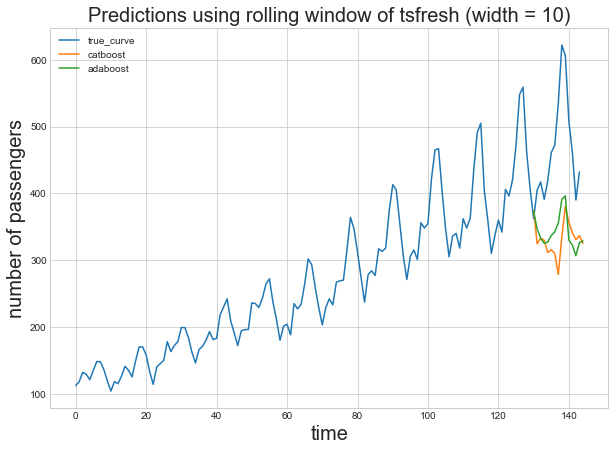

In [119]:
fig = plt.figure(figsize=(10, 7))

plt.plot(data, label = "true_curve")
#plt.plot(data_test.index.values + 1, predictions_lr, label = "linear regression")
plt.plot(data_test.index.values + 1, predictions_cb, label = "catboost")
plt.plot(data_test.index.values + 1, predictions_ab, label = "adaboost")

plt.xlabel("time", size = 20)
plt.ylabel("number of passengers", size = 20)
plt.title("Predictions using rolling window of tsfresh (width = 10)", size = 20)
plt.legend()

plt.show()

# Increase width

# Catboost

In [100]:
for_model_cb.fit(data_train, max_timeshift=len(data_train))

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 274.3859905	total: 35.5ms	remaining: 10.6s
1:	learn: 268.0155971	total: 72.7ms	remaining: 10.8s
2:	learn: 261.4206538	total: 105ms	remaining: 10.4s
3:	learn: 255.9495397	total: 136ms	remaining: 10.1s
4:	learn: 250.3451737	total: 173ms	remaining: 10.2s
5:	learn: 244.5319256	total: 203ms	remaining: 9.96s
6:	learn: 238.5794482	total: 237ms	remaining: 9.9s
7:	learn: 232.7288726	total: 276ms	remaining: 10.1s
8:	learn: 227.2825525	total: 314ms	remaining: 10.1s
9:	learn: 221.8758610	total: 349ms	remaining: 10.1s
10:	learn: 216.9359777	total: 388ms	remaining: 10.2s
11:	learn: 212.1543473	total: 421ms	remaining: 10.1s
12:	learn: 207.7992318	total: 455ms	remaining: 10s
13:	learn: 203.0159409	total: 495ms	remaining: 10.1s
14:	learn: 198.4526289	total: 529ms	remaining: 10s
15:	learn: 193.9875863	total: 557ms	remaining: 9.88s
16:	learn: 189.6942822	total: 586ms	remaining: 9.75s
17:	learn: 185.3335989	total: 614ms	remaining: 9.61s
18:	learn: 181.2327975	total: 642ms	remaining: 9.49s
19:	le

157:	learn: 26.8780064	total: 4.94s	remaining: 4.44s
158:	learn: 26.8375006	total: 4.96s	remaining: 4.39s
159:	learn: 26.7513643	total: 4.99s	remaining: 4.37s
160:	learn: 26.6240353	total: 5.02s	remaining: 4.34s
161:	learn: 26.5677495	total: 5.05s	remaining: 4.3s
162:	learn: 26.4728268	total: 5.09s	remaining: 4.28s
163:	learn: 26.3469179	total: 5.12s	remaining: 4.25s
164:	learn: 26.1356673	total: 5.15s	remaining: 4.22s
165:	learn: 26.0679889	total: 5.19s	remaining: 4.19s
166:	learn: 25.9646553	total: 5.23s	remaining: 4.16s
167:	learn: 25.8856631	total: 5.26s	remaining: 4.13s
168:	learn: 25.7693201	total: 5.28s	remaining: 4.1s
169:	learn: 25.7210700	total: 5.31s	remaining: 4.06s
170:	learn: 25.6027353	total: 5.34s	remaining: 4.03s
171:	learn: 25.5041040	total: 5.37s	remaining: 4s
172:	learn: 25.3965126	total: 5.4s	remaining: 3.96s
173:	learn: 25.2181823	total: 5.43s	remaining: 3.93s
174:	learn: 25.1101583	total: 5.46s	remaining: 3.9s
175:	learn: 24.9983674	total: 5.49s	remaining: 3.87s


In [101]:
predictions_cb_new = for_model_cb.predict(data_test.shape[0])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 275.6090751	total: 41.3ms	remaining: 12.4s
1:	learn: 269.0221101	total: 77.9ms	remaining: 11.6s
2:	learn: 262.8428454	total: 111ms	remaining: 11s
3:	learn: 256.2498309	total: 143ms	remaining: 10.6s
4:	learn: 249.9556199	total: 175ms	remaining: 10.3s
5:	learn: 243.9942109	total: 206ms	remaining: 10.1s
6:	learn: 238.1164099	total: 238ms	remaining: 9.96s
7:	learn: 233.1145265	total: 279ms	remaining: 10.2s
8:	learn: 227.2423025	total: 329ms	remaining: 10.6s
9:	learn: 221.6956633	total: 378ms	remaining: 11s
10:	learn: 216.3153533	total: 417ms	remaining: 10.9s
11:	learn: 211.1123431	total: 467ms	remaining: 11.2s
12:	learn: 206.0852728	total: 518ms	remaining: 11.4s
13:	learn: 201.2698275	total: 559ms	remaining: 11.4s
14:	learn: 196.2490243	total: 602ms	remaining: 11.4s
15:	learn: 191.9529666	total: 642ms	remaining: 11.4s
16:	learn: 187.6877381	total: 686ms	remaining: 11.4s
17:	learn: 183.3690694	total: 727ms	remaining: 11.4s
18:	learn: 179.3323776	total: 765ms	remaining: 11.3s
19:	l

161:	learn: 26.7999605	total: 5.95s	remaining: 5.06s
162:	learn: 26.6911510	total: 5.99s	remaining: 5.03s
163:	learn: 26.5481431	total: 6.02s	remaining: 4.99s
164:	learn: 26.4325967	total: 6.05s	remaining: 4.95s
165:	learn: 26.3376330	total: 6.09s	remaining: 4.91s
166:	learn: 26.1946719	total: 6.12s	remaining: 4.87s
167:	learn: 26.0777493	total: 6.15s	remaining: 4.83s
168:	learn: 25.9126739	total: 6.19s	remaining: 4.8s
169:	learn: 25.8216415	total: 6.22s	remaining: 4.75s
170:	learn: 25.7127168	total: 6.25s	remaining: 4.71s
171:	learn: 25.6682340	total: 6.28s	remaining: 4.67s
172:	learn: 25.4820941	total: 6.31s	remaining: 4.63s
173:	learn: 25.4473325	total: 6.34s	remaining: 4.59s
174:	learn: 25.4017746	total: 6.4s	remaining: 4.57s
175:	learn: 25.3278821	total: 6.45s	remaining: 4.54s
176:	learn: 25.2599634	total: 6.48s	remaining: 4.5s
177:	learn: 25.1508494	total: 6.49s	remaining: 4.45s
178:	learn: 25.0445348	total: 6.53s	remaining: 4.41s
179:	learn: 24.9840606	total: 6.56s	remaining: 4.

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 276.5036643	total: 38.7ms	remaining: 11.6s
1:	learn: 270.0156356	total: 79.6ms	remaining: 11.9s
2:	learn: 263.3540226	total: 116ms	remaining: 11.5s
3:	learn: 257.0712055	total: 155ms	remaining: 11.5s
4:	learn: 250.8758155	total: 189ms	remaining: 11.1s
5:	learn: 244.5963137	total: 221ms	remaining: 10.8s
6:	learn: 238.3248697	total: 240ms	remaining: 10s
7:	learn: 232.5465257	total: 277ms	remaining: 10.1s
8:	learn: 227.1012282	total: 312ms	remaining: 10.1s
9:	learn: 221.8939807	total: 350ms	remaining: 10.1s
10:	learn: 216.2291381	total: 392ms	remaining: 10.3s
11:	learn: 210.9697908	total: 431ms	remaining: 10.4s
12:	learn: 205.8986331	total: 475ms	remaining: 10.5s
13:	learn: 201.4330187	total: 516ms	remaining: 10.5s
14:	learn: 196.9028080	total: 557ms	remaining: 10.6s
15:	learn: 191.9905778	total: 596ms	remaining: 10.6s
16:	learn: 187.2018339	total: 633ms	remaining: 10.5s
17:	learn: 182.8906938	total: 674ms	remaining: 10.6s
18:	learn: 178.7887524	total: 719ms	remaining: 10.6s
19:

157:	learn: 27.1241806	total: 5.78s	remaining: 5.19s
158:	learn: 26.9738218	total: 5.79s	remaining: 5.14s
159:	learn: 26.8580843	total: 5.83s	remaining: 5.1s
160:	learn: 26.7645761	total: 5.86s	remaining: 5.06s
161:	learn: 26.5918996	total: 5.9s	remaining: 5.03s
162:	learn: 26.5123214	total: 5.92s	remaining: 4.98s
163:	learn: 26.3665045	total: 5.96s	remaining: 4.94s
164:	learn: 26.3151805	total: 6s	remaining: 4.91s
165:	learn: 26.1858465	total: 6.04s	remaining: 4.87s
166:	learn: 26.1470520	total: 6.07s	remaining: 4.83s
167:	learn: 26.0037879	total: 6.11s	remaining: 4.8s
168:	learn: 25.8655267	total: 6.14s	remaining: 4.76s
169:	learn: 25.7716821	total: 6.17s	remaining: 4.72s
170:	learn: 25.7164452	total: 6.21s	remaining: 4.68s
171:	learn: 25.6927911	total: 6.25s	remaining: 4.65s
172:	learn: 25.6240554	total: 6.27s	remaining: 4.6s
173:	learn: 25.5638759	total: 6.31s	remaining: 4.57s
174:	learn: 25.4851114	total: 6.34s	remaining: 4.53s
175:	learn: 25.3875912	total: 6.38s	remaining: 4.49s


/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 276.8941052	total: 31.8ms	remaining: 9.51s
1:	learn: 270.6770408	total: 63.1ms	remaining: 9.41s
2:	learn: 264.9982075	total: 94.8ms	remaining: 9.38s
3:	learn: 258.3520108	total: 126ms	remaining: 9.32s
4:	learn: 252.0609560	total: 157ms	remaining: 9.24s
5:	learn: 245.5034964	total: 188ms	remaining: 9.2s
6:	learn: 239.3382453	total: 219ms	remaining: 9.15s
7:	learn: 233.9111676	total: 253ms	remaining: 9.23s
8:	learn: 228.3933633	total: 287ms	remaining: 9.29s
9:	learn: 222.9782318	total: 318ms	remaining: 9.23s
10:	learn: 217.7587240	total: 352ms	remaining: 9.25s
11:	learn: 212.5661406	total: 385ms	remaining: 9.25s
12:	learn: 207.5245894	total: 423ms	remaining: 9.34s
13:	learn: 202.3753287	total: 462ms	remaining: 9.44s
14:	learn: 197.3825095	total: 500ms	remaining: 9.5s
15:	learn: 193.0078647	total: 533ms	remaining: 9.47s
16:	learn: 188.5058925	total: 566ms	remaining: 9.42s
17:	learn: 184.0470243	total: 597ms	remaining: 9.36s
18:	learn: 179.7167613	total: 629ms	remaining: 9.3s
19:

157:	learn: 27.1755568	total: 5.14s	remaining: 4.62s
158:	learn: 27.0160079	total: 5.17s	remaining: 4.59s
159:	learn: 26.9349811	total: 5.21s	remaining: 4.55s
160:	learn: 26.8179643	total: 5.24s	remaining: 4.52s
161:	learn: 26.6830330	total: 5.27s	remaining: 4.49s
162:	learn: 26.5648169	total: 5.3s	remaining: 4.45s
163:	learn: 26.4527461	total: 5.33s	remaining: 4.42s
164:	learn: 26.3612204	total: 5.37s	remaining: 4.39s
165:	learn: 26.2619220	total: 5.4s	remaining: 4.36s
166:	learn: 26.1863411	total: 5.43s	remaining: 4.33s
167:	learn: 26.1525711	total: 5.44s	remaining: 4.28s
168:	learn: 26.0749110	total: 5.47s	remaining: 4.24s
169:	learn: 26.0158148	total: 5.51s	remaining: 4.21s
170:	learn: 25.8943942	total: 5.54s	remaining: 4.18s
171:	learn: 25.8476610	total: 5.57s	remaining: 4.15s
172:	learn: 25.7579846	total: 5.61s	remaining: 4.12s
173:	learn: 25.6780174	total: 5.64s	remaining: 4.09s
174:	learn: 25.5399428	total: 5.68s	remaining: 4.05s
175:	learn: 25.4641376	total: 5.71s	remaining: 4

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 276.4424681	total: 32.4ms	remaining: 9.68s
1:	learn: 269.8638793	total: 64.1ms	remaining: 9.55s
2:	learn: 264.1141950	total: 95.7ms	remaining: 9.48s
3:	learn: 257.1672485	total: 127ms	remaining: 9.41s
4:	learn: 250.9137810	total: 159ms	remaining: 9.36s
5:	learn: 244.7143376	total: 190ms	remaining: 9.32s
6:	learn: 238.6843658	total: 222ms	remaining: 9.29s
7:	learn: 232.6698222	total: 255ms	remaining: 9.31s
8:	learn: 226.5329386	total: 280ms	remaining: 9.05s
9:	learn: 220.8352803	total: 312ms	remaining: 9.04s
10:	learn: 215.6854988	total: 344ms	remaining: 9.05s
11:	learn: 210.4299870	total: 380ms	remaining: 9.12s
12:	learn: 205.2537273	total: 415ms	remaining: 9.16s
13:	learn: 200.2238915	total: 450ms	remaining: 9.18s
14:	learn: 194.9986335	total: 489ms	remaining: 9.29s
15:	learn: 190.4872228	total: 524ms	remaining: 9.3s
16:	learn: 185.8493058	total: 557ms	remaining: 9.27s
17:	learn: 181.4598205	total: 589ms	remaining: 9.23s
18:	learn: 177.1997168	total: 621ms	remaining: 9.18s
1

159:	learn: 25.0050966	total: 5.25s	remaining: 4.6s
160:	learn: 24.9003805	total: 5.29s	remaining: 4.56s
161:	learn: 24.8371935	total: 5.32s	remaining: 4.53s
162:	learn: 24.7178783	total: 5.35s	remaining: 4.5s
163:	learn: 24.6144080	total: 5.37s	remaining: 4.45s
164:	learn: 24.4179198	total: 5.39s	remaining: 4.41s
165:	learn: 24.3726894	total: 5.42s	remaining: 4.37s
166:	learn: 24.2255924	total: 5.45s	remaining: 4.34s
167:	learn: 24.1487252	total: 5.49s	remaining: 4.31s
168:	learn: 24.0915611	total: 5.52s	remaining: 4.28s
169:	learn: 24.0184305	total: 5.55s	remaining: 4.25s
170:	learn: 23.9477679	total: 5.58s	remaining: 4.21s
171:	learn: 23.8676096	total: 5.61s	remaining: 4.18s
172:	learn: 23.8014245	total: 5.65s	remaining: 4.14s
173:	learn: 23.6755069	total: 5.68s	remaining: 4.11s
174:	learn: 23.5932374	total: 5.71s	remaining: 4.08s
175:	learn: 23.4787343	total: 5.75s	remaining: 4.05s
176:	learn: 23.3642988	total: 5.79s	remaining: 4.02s
177:	learn: 23.3220035	total: 5.82s	remaining: 3

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 277.2445727	total: 33.1ms	remaining: 9.91s
1:	learn: 270.3134830	total: 65.5ms	remaining: 9.75s
2:	learn: 263.6165074	total: 97.8ms	remaining: 9.68s
3:	learn: 257.2586780	total: 130ms	remaining: 9.59s
4:	learn: 251.1514344	total: 161ms	remaining: 9.53s
5:	learn: 244.8122473	total: 193ms	remaining: 9.46s
6:	learn: 238.7908599	total: 225ms	remaining: 9.43s
7:	learn: 232.7666788	total: 262ms	remaining: 9.57s
8:	learn: 227.2473640	total: 296ms	remaining: 9.58s
9:	learn: 221.8380490	total: 329ms	remaining: 9.55s
10:	learn: 216.8299682	total: 364ms	remaining: 9.57s
11:	learn: 211.4144062	total: 398ms	remaining: 9.54s
12:	learn: 206.3410861	total: 432ms	remaining: 9.53s
13:	learn: 201.6146067	total: 467ms	remaining: 9.53s
14:	learn: 196.7945479	total: 503ms	remaining: 9.56s
15:	learn: 191.7970753	total: 538ms	remaining: 9.54s
16:	learn: 187.1614630	total: 571ms	remaining: 9.5s
17:	learn: 182.4458069	total: 603ms	remaining: 9.45s
18:	learn: 178.4454357	total: 636ms	remaining: 9.4s
19

162:	learn: 25.8412373	total: 5.31s	remaining: 4.46s
163:	learn: 25.7559142	total: 5.35s	remaining: 4.43s
164:	learn: 25.7018241	total: 5.38s	remaining: 4.4s
165:	learn: 25.5773690	total: 5.41s	remaining: 4.37s
166:	learn: 25.5054205	total: 5.44s	remaining: 4.33s
167:	learn: 25.3667770	total: 5.47s	remaining: 4.3s
168:	learn: 25.3199769	total: 5.51s	remaining: 4.27s
169:	learn: 25.2588105	total: 5.52s	remaining: 4.22s
170:	learn: 25.1826237	total: 5.56s	remaining: 4.19s
171:	learn: 25.1141390	total: 5.59s	remaining: 4.16s
172:	learn: 25.0032919	total: 5.62s	remaining: 4.13s
173:	learn: 24.9457147	total: 5.65s	remaining: 4.09s
174:	learn: 24.8626477	total: 5.68s	remaining: 4.06s
175:	learn: 24.8126873	total: 5.72s	remaining: 4.03s
176:	learn: 24.7477182	total: 5.75s	remaining: 4s
177:	learn: 24.6358326	total: 5.79s	remaining: 3.97s
178:	learn: 24.5628413	total: 5.82s	remaining: 3.94s
179:	learn: 24.5028511	total: 5.85s	remaining: 3.9s
180:	learn: 24.4607258	total: 5.87s	remaining: 3.86s

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 277.2150926	total: 33ms	remaining: 9.86s
1:	learn: 269.9405682	total: 64.9ms	remaining: 9.68s
2:	learn: 263.6477963	total: 97.5ms	remaining: 9.65s
3:	learn: 257.2889466	total: 130ms	remaining: 9.6s
4:	learn: 250.8769633	total: 162ms	remaining: 9.55s
5:	learn: 244.8316220	total: 194ms	remaining: 9.52s
6:	learn: 238.7779310	total: 227ms	remaining: 9.52s
7:	learn: 233.4206600	total: 266ms	remaining: 9.72s
8:	learn: 227.8030895	total: 299ms	remaining: 9.68s
9:	learn: 222.1838211	total: 332ms	remaining: 9.64s
10:	learn: 216.9237236	total: 367ms	remaining: 9.65s
11:	learn: 211.5268249	total: 402ms	remaining: 9.66s
12:	learn: 206.3238020	total: 438ms	remaining: 9.68s
13:	learn: 201.3021392	total: 474ms	remaining: 9.68s
14:	learn: 196.4511096	total: 510ms	remaining: 9.69s
15:	learn: 191.7034721	total: 545ms	remaining: 9.68s
16:	learn: 187.3221270	total: 578ms	remaining: 9.63s
17:	learn: 182.6696145	total: 611ms	remaining: 9.58s
18:	learn: 178.3872755	total: 644ms	remaining: 9.52s
19:

162:	learn: 26.6921573	total: 5.42s	remaining: 4.56s
163:	learn: 26.5340091	total: 5.46s	remaining: 4.52s
164:	learn: 26.4707845	total: 5.49s	remaining: 4.49s
165:	learn: 26.3921561	total: 5.52s	remaining: 4.46s
166:	learn: 26.2619932	total: 5.55s	remaining: 4.42s
167:	learn: 26.1152259	total: 5.58s	remaining: 4.39s
168:	learn: 26.0197090	total: 5.62s	remaining: 4.35s
169:	learn: 25.9654981	total: 5.65s	remaining: 4.32s
170:	learn: 25.8349008	total: 5.69s	remaining: 4.29s
171:	learn: 25.6430142	total: 5.72s	remaining: 4.26s
172:	learn: 25.5081773	total: 5.75s	remaining: 4.22s
173:	learn: 25.3975133	total: 5.78s	remaining: 4.19s
174:	learn: 25.2992610	total: 5.82s	remaining: 4.15s
175:	learn: 25.2791639	total: 5.85s	remaining: 4.12s
176:	learn: 25.1208491	total: 5.89s	remaining: 4.09s
177:	learn: 25.0451832	total: 5.92s	remaining: 4.06s
178:	learn: 24.9219297	total: 5.96s	remaining: 4.03s
179:	learn: 24.8637854	total: 5.99s	remaining: 3.99s
180:	learn: 24.8126427	total: 6.03s	remaining:

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__fft_coefficient__coeff_65__attr_"abs"'
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr

0:	learn: 276.8648249	total: 34.6ms	remaining: 10.3s
1:	learn: 270.1653458	total: 67.7ms	remaining: 10.1s
2:	learn: 263.5173532	total: 101ms	remaining: 10s
3:	learn: 257.2550383	total: 134ms	remaining: 9.9s
4:	learn: 250.7518926	total: 167ms	remaining: 9.85s
5:	learn: 244.2034413	total: 200ms	remaining: 9.78s
6:	learn: 238.2347642	total: 233ms	remaining: 9.75s
7:	learn: 232.3201816	total: 276ms	remaining: 10.1s
8:	learn: 226.9800419	total: 310ms	remaining: 10s
9:	learn: 221.6091594	total: 344ms	remaining: 9.98s
10:	learn: 216.0934992	total: 380ms	remaining: 9.97s
11:	learn: 210.8145409	total: 416ms	remaining: 9.98s
12:	learn: 205.9898219	total: 451ms	remaining: 9.95s
13:	learn: 201.1837837	total: 487ms	remaining: 9.95s
14:	learn: 196.2628208	total: 527ms	remaining: 10s
15:	learn: 191.5537779	total: 561ms	remaining: 9.95s
16:	learn: 186.8970680	total: 594ms	remaining: 9.88s
17:	learn: 182.5497026	total: 626ms	remaining: 9.81s
18:	learn: 178.2632899	total: 659ms	remaining: 9.75s
19:	lear

161:	learn: 25.4621013	total: 5.48s	remaining: 4.67s
162:	learn: 25.3460326	total: 5.52s	remaining: 4.64s
163:	learn: 25.2195971	total: 5.55s	remaining: 4.6s
164:	learn: 25.1024699	total: 5.58s	remaining: 4.57s
165:	learn: 25.0721359	total: 5.62s	remaining: 4.53s
166:	learn: 24.9671933	total: 5.64s	remaining: 4.49s
167:	learn: 24.8978095	total: 5.67s	remaining: 4.45s
168:	learn: 24.7838351	total: 5.71s	remaining: 4.42s
169:	learn: 24.7540641	total: 5.74s	remaining: 4.39s
170:	learn: 24.7047251	total: 5.77s	remaining: 4.35s
171:	learn: 24.6080394	total: 5.8s	remaining: 4.32s
172:	learn: 24.5095050	total: 5.84s	remaining: 4.29s
173:	learn: 24.4543206	total: 5.87s	remaining: 4.25s
174:	learn: 24.3762904	total: 5.9s	remaining: 4.22s
175:	learn: 24.2982419	total: 5.94s	remaining: 4.18s
176:	learn: 24.1892448	total: 5.97s	remaining: 4.15s
177:	learn: 24.0561551	total: 6.01s	remaining: 4.12s
178:	learn: 23.9763264	total: 6.04s	remaining: 4.09s
179:	learn: 23.8847996	total: 6.08s	remaining: 4.

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 276.4127874	total: 8.09ms	remaining: 2.42s
1:	learn: 270.1414001	total: 41.8ms	remaining: 6.23s
2:	learn: 263.6131229	total: 74.9ms	remaining: 7.41s
3:	learn: 257.2861102	total: 108ms	remaining: 7.97s
4:	learn: 250.9615683	total: 141ms	remaining: 8.29s
5:	learn: 244.9430218	total: 175ms	remaining: 8.56s
6:	learn: 238.5859226	total: 208ms	remaining: 8.7s
7:	learn: 233.0695439	total: 247ms	remaining: 9.02s
8:	learn: 227.3555725	total: 282ms	remaining: 9.12s
9:	learn: 221.8549230	total: 315ms	remaining: 9.14s
10:	learn: 217.1162215	total: 351ms	remaining: 9.21s
11:	learn: 211.9129355	total: 386ms	remaining: 9.26s
12:	learn: 206.7431902	total: 422ms	remaining: 9.31s
13:	learn: 201.7267433	total: 461ms	remaining: 9.41s
14:	learn: 197.0290852	total: 495ms	remaining: 9.41s
15:	learn: 192.2537016	total: 530ms	remaining: 9.41s
16:	learn: 188.0997738	total: 563ms	remaining: 9.37s
17:	learn: 183.8912728	total: 596ms	remaining: 9.33s
18:	learn: 179.3813676	total: 630ms	remaining: 9.31s
1

158:	learn: 26.7850118	total: 5.25s	remaining: 4.65s
159:	learn: 26.7341402	total: 5.27s	remaining: 4.61s
160:	learn: 26.6341704	total: 5.31s	remaining: 4.58s
161:	learn: 26.5944655	total: 5.34s	remaining: 4.55s
162:	learn: 26.4905284	total: 5.37s	remaining: 4.51s
163:	learn: 26.3560963	total: 5.41s	remaining: 4.48s
164:	learn: 26.3231100	total: 5.44s	remaining: 4.45s
165:	learn: 26.2121831	total: 5.47s	remaining: 4.42s
166:	learn: 26.1784587	total: 5.51s	remaining: 4.39s
167:	learn: 26.0444798	total: 5.54s	remaining: 4.35s
168:	learn: 25.9770907	total: 5.57s	remaining: 4.32s
169:	learn: 25.8523111	total: 5.61s	remaining: 4.29s
170:	learn: 25.7861709	total: 5.64s	remaining: 4.25s
171:	learn: 25.6539638	total: 5.67s	remaining: 4.22s
172:	learn: 25.5890102	total: 5.71s	remaining: 4.19s
173:	learn: 25.5505813	total: 5.75s	remaining: 4.16s
174:	learn: 25.5090567	total: 5.78s	remaining: 4.13s
175:	learn: 25.4255175	total: 5.82s	remaining: 4.1s
176:	learn: 25.3854366	total: 5.85s	remaining: 

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 276.0266004	total: 19.6ms	remaining: 5.86s
1:	learn: 269.0506850	total: 53.3ms	remaining: 7.95s
2:	learn: 262.1724520	total: 86.2ms	remaining: 8.54s
3:	learn: 256.1425690	total: 120ms	remaining: 8.84s
4:	learn: 249.9492790	total: 152ms	remaining: 8.98s
5:	learn: 244.0463984	total: 185ms	remaining: 9.07s
6:	learn: 238.1138006	total: 218ms	remaining: 9.12s
7:	learn: 232.4698017	total: 256ms	remaining: 9.34s
8:	learn: 226.7803272	total: 289ms	remaining: 9.35s
9:	learn: 221.2217640	total: 322ms	remaining: 9.35s
10:	learn: 215.9548694	total: 359ms	remaining: 9.42s
11:	learn: 210.6971726	total: 379ms	remaining: 9.09s
12:	learn: 205.5563228	total: 414ms	remaining: 9.13s
13:	learn: 200.6187445	total: 449ms	remaining: 9.17s
14:	learn: 195.9420447	total: 485ms	remaining: 9.21s
15:	learn: 191.4030898	total: 523ms	remaining: 9.29s
16:	learn: 186.8589747	total: 557ms	remaining: 9.27s
17:	learn: 182.3353143	total: 591ms	remaining: 9.26s
18:	learn: 177.7738479	total: 626ms	remaining: 9.25s


162:	learn: 26.6454269	total: 5.54s	remaining: 4.65s
163:	learn: 26.5236427	total: 5.58s	remaining: 4.62s
164:	learn: 26.3427202	total: 5.61s	remaining: 4.59s
165:	learn: 26.2414702	total: 5.64s	remaining: 4.55s
166:	learn: 26.1365032	total: 5.68s	remaining: 4.52s
167:	learn: 26.0297393	total: 5.71s	remaining: 4.49s
168:	learn: 25.8967811	total: 5.74s	remaining: 4.45s
169:	learn: 25.8011724	total: 5.78s	remaining: 4.42s
170:	learn: 25.6150003	total: 5.82s	remaining: 4.39s
171:	learn: 25.5152115	total: 5.85s	remaining: 4.35s
172:	learn: 25.4218945	total: 5.88s	remaining: 4.32s
173:	learn: 25.3053571	total: 5.92s	remaining: 4.28s
174:	learn: 25.2148400	total: 5.95s	remaining: 4.25s
175:	learn: 25.1594569	total: 5.99s	remaining: 4.22s
176:	learn: 25.0645144	total: 6.02s	remaining: 4.18s
177:	learn: 24.9999245	total: 6.06s	remaining: 4.15s
178:	learn: 24.9130247	total: 6.09s	remaining: 4.12s
179:	learn: 24.8559678	total: 6.13s	remaining: 4.08s
180:	learn: 24.7193943	total: 6.16s	remaining:

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 275.6686074	total: 34ms	remaining: 10.2s
1:	learn: 268.7606490	total: 68ms	remaining: 10.1s
2:	learn: 262.3226769	total: 102ms	remaining: 10.1s
3:	learn: 255.9387093	total: 135ms	remaining: 9.99s
4:	learn: 249.8182227	total: 169ms	remaining: 9.95s
5:	learn: 243.7592232	total: 202ms	remaining: 9.91s
6:	learn: 237.9163145	total: 239ms	remaining: 10s
7:	learn: 232.1437705	total: 279ms	remaining: 10.2s
8:	learn: 226.4407710	total: 314ms	remaining: 10.1s
9:	learn: 221.1305145	total: 349ms	remaining: 10.1s
10:	learn: 215.9492484	total: 385ms	remaining: 10.1s
11:	learn: 210.8928549	total: 421ms	remaining: 10.1s
12:	learn: 205.7913914	total: 460ms	remaining: 10.1s
13:	learn: 201.0968088	total: 497ms	remaining: 10.2s
14:	learn: 196.0916493	total: 532ms	remaining: 10.1s
15:	learn: 191.2530929	total: 566ms	remaining: 10s
16:	learn: 186.6974999	total: 599ms	remaining: 9.97s
17:	learn: 182.3456705	total: 632ms	remaining: 9.9s
18:	learn: 177.9624335	total: 668ms	remaining: 9.88s
19:	learn:

159:	learn: 27.0114041	total: 5.57s	remaining: 4.87s
160:	learn: 26.9138803	total: 5.6s	remaining: 4.84s
161:	learn: 26.8403380	total: 5.64s	remaining: 4.8s
162:	learn: 26.7738970	total: 5.67s	remaining: 4.77s
163:	learn: 26.6935852	total: 5.71s	remaining: 4.73s
164:	learn: 26.5413884	total: 5.74s	remaining: 4.7s
165:	learn: 26.4546156	total: 5.78s	remaining: 4.66s
166:	learn: 26.3157785	total: 5.81s	remaining: 4.63s
167:	learn: 26.2844581	total: 5.85s	remaining: 4.59s
168:	learn: 26.2010341	total: 5.88s	remaining: 4.56s
169:	learn: 26.0997215	total: 5.91s	remaining: 4.52s
170:	learn: 26.0303305	total: 5.95s	remaining: 4.49s
171:	learn: 25.8918011	total: 5.98s	remaining: 4.45s
172:	learn: 25.8120971	total: 6.02s	remaining: 4.42s
173:	learn: 25.7493137	total: 6.05s	remaining: 4.38s
174:	learn: 25.6366954	total: 6.09s	remaining: 4.35s
175:	learn: 25.5572923	total: 6.12s	remaining: 4.31s
176:	learn: 25.5019605	total: 6.16s	remaining: 4.28s
177:	learn: 25.4265843	total: 6.19s	remaining: 4.

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 275.6867845	total: 33.9ms	remaining: 10.1s
1:	learn: 268.7419539	total: 67.7ms	remaining: 10.1s
2:	learn: 261.9273377	total: 101ms	remaining: 10s
3:	learn: 255.5573142	total: 135ms	remaining: 9.97s
4:	learn: 249.8440542	total: 168ms	remaining: 9.94s
5:	learn: 243.6055237	total: 203ms	remaining: 9.94s
6:	learn: 237.4534913	total: 238ms	remaining: 9.96s
7:	learn: 231.4526666	total: 275ms	remaining: 10s
8:	learn: 226.0163021	total: 311ms	remaining: 10.1s
9:	learn: 220.3187756	total: 347ms	remaining: 10.1s
10:	learn: 215.0451088	total: 384ms	remaining: 10.1s
11:	learn: 210.0011265	total: 420ms	remaining: 10.1s
12:	learn: 205.0718384	total: 457ms	remaining: 10.1s
13:	learn: 199.8365997	total: 495ms	remaining: 10.1s
14:	learn: 194.8093308	total: 530ms	remaining: 10.1s
15:	learn: 190.1530527	total: 565ms	remaining: 10s
16:	learn: 185.4732370	total: 599ms	remaining: 9.97s
17:	learn: 181.1177969	total: 632ms	remaining: 9.9s
18:	learn: 176.7290495	total: 667ms	remaining: 9.86s
19:	lear

162:	learn: 25.8008703	total: 5.64s	remaining: 4.74s
163:	learn: 25.6267185	total: 5.68s	remaining: 4.71s
164:	learn: 25.5789031	total: 5.71s	remaining: 4.67s
165:	learn: 25.4270763	total: 5.75s	remaining: 4.64s
166:	learn: 25.3278230	total: 5.78s	remaining: 4.6s
167:	learn: 25.2411589	total: 5.81s	remaining: 4.57s
168:	learn: 25.1363491	total: 5.85s	remaining: 4.53s
169:	learn: 25.0713035	total: 5.89s	remaining: 4.5s
170:	learn: 24.9408357	total: 5.92s	remaining: 4.47s
171:	learn: 24.8453308	total: 5.95s	remaining: 4.43s
172:	learn: 24.7703858	total: 5.99s	remaining: 4.39s
173:	learn: 24.6760942	total: 6.02s	remaining: 4.36s
174:	learn: 24.5832462	total: 6.05s	remaining: 4.33s
175:	learn: 24.4979804	total: 6.09s	remaining: 4.29s
176:	learn: 24.4089383	total: 6.13s	remaining: 4.26s
177:	learn: 24.3519104	total: 6.17s	remaining: 4.23s
178:	learn: 24.2699075	total: 6.2s	remaining: 4.19s
179:	learn: 24.1985993	total: 6.24s	remaining: 4.16s
180:	learn: 24.1466429	total: 6.28s	remaining: 4.

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 275.2255737	total: 35.5ms	remaining: 10.6s
1:	learn: 268.3398087	total: 70.3ms	remaining: 10.5s
2:	learn: 261.5142653	total: 105ms	remaining: 10.4s
3:	learn: 255.2548329	total: 139ms	remaining: 10.3s
4:	learn: 249.2544898	total: 174ms	remaining: 10.3s
5:	learn: 243.8217100	total: 210ms	remaining: 10.3s
6:	learn: 238.1177909	total: 245ms	remaining: 10.3s
7:	learn: 232.6202037	total: 286ms	remaining: 10.4s
8:	learn: 227.1406013	total: 322ms	remaining: 10.4s
9:	learn: 221.4611824	total: 358ms	remaining: 10.4s
10:	learn: 216.1376462	total: 394ms	remaining: 10.3s
11:	learn: 211.1934236	total: 430ms	remaining: 10.3s
12:	learn: 206.1332473	total: 470ms	remaining: 10.4s
13:	learn: 201.2702520	total: 508ms	remaining: 10.4s
14:	learn: 196.2112305	total: 543ms	remaining: 10.3s
15:	learn: 191.4956944	total: 578ms	remaining: 10.3s
16:	learn: 186.8576577	total: 583ms	remaining: 9.7s
17:	learn: 182.5491132	total: 617ms	remaining: 9.66s
18:	learn: 178.3098277	total: 651ms	remaining: 9.63s
19

158:	learn: 26.6561416	total: 5.63s	remaining: 5s
159:	learn: 26.5769269	total: 5.67s	remaining: 4.96s
160:	learn: 26.4137857	total: 5.71s	remaining: 4.93s
161:	learn: 26.2712803	total: 5.74s	remaining: 4.89s
162:	learn: 26.1445408	total: 5.78s	remaining: 4.86s
163:	learn: 26.0641824	total: 5.81s	remaining: 4.82s
164:	learn: 25.9643507	total: 5.85s	remaining: 4.78s
165:	learn: 25.8743084	total: 5.88s	remaining: 4.75s
166:	learn: 25.6895402	total: 5.92s	remaining: 4.71s
167:	learn: 25.5725751	total: 5.95s	remaining: 4.68s
168:	learn: 25.4611298	total: 5.99s	remaining: 4.64s
169:	learn: 25.4073905	total: 6.02s	remaining: 4.61s
170:	learn: 25.3133067	total: 6.04s	remaining: 4.56s
171:	learn: 25.2060229	total: 6.08s	remaining: 4.53s
172:	learn: 25.1282091	total: 6.12s	remaining: 4.49s
173:	learn: 25.0428294	total: 6.15s	remaining: 4.46s
174:	learn: 25.0246354	total: 6.19s	remaining: 4.42s
175:	learn: 24.9085201	total: 6.23s	remaining: 4.39s
176:	learn: 24.8201973	total: 6.26s	remaining: 4.

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 274.7690550	total: 35.7ms	remaining: 10.7s
1:	learn: 268.3057315	total: 70.4ms	remaining: 10.5s
2:	learn: 261.9257951	total: 106ms	remaining: 10.5s
3:	learn: 255.3466115	total: 140ms	remaining: 10.4s
4:	learn: 249.6514111	total: 175ms	remaining: 10.3s
5:	learn: 244.0757395	total: 210ms	remaining: 10.3s
6:	learn: 237.8592286	total: 246ms	remaining: 10.3s
7:	learn: 231.7631818	total: 285ms	remaining: 10.4s
8:	learn: 225.8246643	total: 321ms	remaining: 10.4s
9:	learn: 220.4484178	total: 358ms	remaining: 10.4s
10:	learn: 215.2507028	total: 394ms	remaining: 10.4s
11:	learn: 209.9777060	total: 430ms	remaining: 10.3s
12:	learn: 204.8110754	total: 469ms	remaining: 10.3s
13:	learn: 199.8259910	total: 508ms	remaining: 10.4s
14:	learn: 194.9020774	total: 554ms	remaining: 10.5s
15:	learn: 190.3417667	total: 591ms	remaining: 10.5s
16:	learn: 185.7201238	total: 629ms	remaining: 10.5s
17:	learn: 181.0517208	total: 675ms	remaining: 10.6s
18:	learn: 176.9872093	total: 716ms	remaining: 10.6s
1

160:	learn: 26.5330769	total: 6.44s	remaining: 5.56s
161:	learn: 26.4502104	total: 6.48s	remaining: 5.52s
162:	learn: 26.4105838	total: 6.51s	remaining: 5.47s
163:	learn: 26.3130284	total: 6.55s	remaining: 5.43s
164:	learn: 26.2495460	total: 6.58s	remaining: 5.38s
165:	learn: 26.1662170	total: 6.62s	remaining: 5.34s
166:	learn: 26.1070809	total: 6.65s	remaining: 5.3s
167:	learn: 25.8493144	total: 6.69s	remaining: 5.26s
168:	learn: 25.7105243	total: 6.73s	remaining: 5.21s
169:	learn: 25.6157785	total: 6.76s	remaining: 5.17s
170:	learn: 25.5532564	total: 6.8s	remaining: 5.13s
171:	learn: 25.4734601	total: 6.83s	remaining: 5.08s
172:	learn: 25.3741552	total: 6.87s	remaining: 5.04s
173:	learn: 25.2816544	total: 6.91s	remaining: 5s
174:	learn: 25.1807810	total: 6.95s	remaining: 4.96s
175:	learn: 25.0984883	total: 6.99s	remaining: 4.92s
176:	learn: 25.0078273	total: 7.04s	remaining: 4.89s
177:	learn: 24.9196041	total: 7.08s	remaining: 4.86s
178:	learn: 24.8515314	total: 7.13s	remaining: 4.82

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

0:	learn: 274.1007544	total: 36ms	remaining: 10.8s
1:	learn: 267.4862478	total: 71.6ms	remaining: 10.7s
2:	learn: 260.9139020	total: 112ms	remaining: 11.1s
3:	learn: 254.1411031	total: 152ms	remaining: 11.2s
4:	learn: 247.6941460	total: 189ms	remaining: 11.1s
5:	learn: 241.7133774	total: 228ms	remaining: 11.2s
6:	learn: 236.7348608	total: 274ms	remaining: 11.5s
7:	learn: 231.2574150	total: 315ms	remaining: 11.5s
8:	learn: 225.6637497	total: 362ms	remaining: 11.7s
9:	learn: 220.2058329	total: 404ms	remaining: 11.7s
10:	learn: 214.9801649	total: 446ms	remaining: 11.7s
11:	learn: 209.7614354	total: 488ms	remaining: 11.7s
12:	learn: 204.6155757	total: 532ms	remaining: 11.7s
13:	learn: 199.7265054	total: 573ms	remaining: 11.7s
14:	learn: 195.0454647	total: 613ms	remaining: 11.6s
15:	learn: 190.0813823	total: 649ms	remaining: 11.5s
16:	learn: 185.6653533	total: 684ms	remaining: 11.4s
17:	learn: 181.2328780	total: 722ms	remaining: 11.3s
18:	learn: 176.6802941	total: 759ms	remaining: 11.2s
19:

162:	learn: 26.0399030	total: 5.99s	remaining: 5.04s
163:	learn: 25.8913818	total: 6.03s	remaining: 5s
164:	learn: 25.8087292	total: 6.07s	remaining: 4.96s
165:	learn: 25.6803601	total: 6.1s	remaining: 4.92s
166:	learn: 25.5416801	total: 6.14s	remaining: 4.89s
167:	learn: 25.4860459	total: 6.17s	remaining: 4.85s
168:	learn: 25.4070250	total: 6.21s	remaining: 4.81s
169:	learn: 25.3247795	total: 6.25s	remaining: 4.78s
170:	learn: 25.2376237	total: 6.28s	remaining: 4.74s
171:	learn: 25.1695158	total: 6.32s	remaining: 4.7s
172:	learn: 25.0315551	total: 6.35s	remaining: 4.66s
173:	learn: 24.9550369	total: 6.39s	remaining: 4.63s
174:	learn: 24.8275520	total: 6.42s	remaining: 4.59s
175:	learn: 24.6969389	total: 6.46s	remaining: 4.55s
176:	learn: 24.6650747	total: 6.5s	remaining: 4.52s
177:	learn: 24.5451548	total: 6.54s	remaining: 4.48s
178:	learn: 24.4465812	total: 6.58s	remaining: 4.45s
179:	learn: 24.3669055	total: 6.62s	remaining: 4.41s
180:	learn: 24.3397974	total: 6.66s	remaining: 4.38s

In [102]:
predictions_cb_new

array([429.65771208, 383.06147823, 324.50626241, 290.8846427 ,
       295.3559093 , 308.44101527, 282.69396874, 237.73479491,
       240.10285815, 216.17109829, 203.90336199, 214.44050746,
       209.51187893, 198.95717079, 201.87211643])

# Adaboost 

In [103]:
for_model_ab.fit(data_train, max_timeshift=len(data_train))

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [104]:
predictions_ab_new = for_model_ab.predict(data_test.shape[0])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__fft_coefficient__coeff_65__attr_"abs"'
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

In [105]:
predictions_ab_new

array([405.33333333, 403.79047619, 414.0033462 , 414.94871795,
       415.44444444, 414.98527303, 411.07864877, 410.00315117,
       416.01090826, 457.42349958, 441.97104001, 427.40893243,
       426.24811648, 417.41876728, 430.78133915])

# Linear Regression

In [106]:
for_model_lr.fit(data_train, max_timeshift=len(data_train))

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

In [107]:
predictions_lr_new = for_model_lr.predict(data_test.shape[0])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]WARNING:tsfresh.utilities.dataframe_functions:The columns ['value__fft_coefficient__coeff_65__attr_"abs"'
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)

Feature Extraction: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]
 'value__fft_coefficient__coeff_65__attr_"angle"'
 'value__fft_coefficient__coeff_65__attr_"imag"'
 'value__fft_coefficient__coeff_65__attr_"real"'
 'value__fft_coefficient__coeff_66__attr_"abs"'
 'value__fft_coefficient__coeff_66__attr_"angle"

In [108]:
predictions_lr_new

array([363.06132875, 290.61965875, 208.7831435 , 313.67489314,
       372.33964743, 442.06430671, 603.20663683, 263.16094512,
       276.97855755, 283.08267188, 487.39154106, 663.46523318,
       574.3538183 , 440.69607058,  48.85579646])

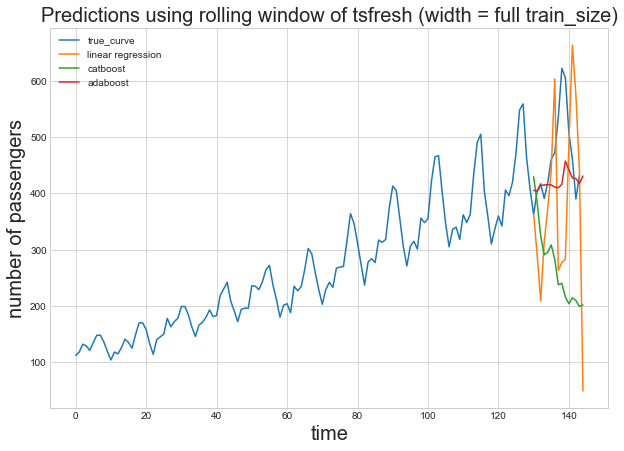

In [109]:
fig = plt.figure(figsize=(10, 7))

plt.plot(data, label = "true_curve")
plt.plot(data_test.index.values + 1, predictions_lr_new, label = "linear regression")
plt.plot(data_test.index.values + 1, predictions_cb_new, label = "catboost")
plt.plot(data_test.index.values + 1, predictions_ab_new, label = "adaboost")

plt.xlabel("time", size = 20)
plt.ylabel("number of passengers", size = 20)
plt.title("Predictions using rolling window of tsfresh (width = full train_size)", size = 20)
plt.legend()

plt.show()

# Checking step-by-step, to prove that everything is fine

In [71]:
# model = LinearRegression()
model = AdaBoostRegressor(random_state = 123)

In [72]:
df_shift, y = make_forecasting_frame(np.append(data_train, 0), kind = "price", 
                            max_timeshift = 10, rolling_direction = 1)
        
X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                                        column_value="value", impute_function=impute, show_warnings=False)
X_train.dropna(axis = 1, inplace = True)
model.fit(X_train[: -1: 1], data_train[1: : 1])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"_

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123)

In [73]:
cur_pred = model.predict(X_train.iloc[-1][None, :])
cur_pred

array([373.09302326])

In [74]:
data_train_b = np.append(data_train, cur_pred)

In [75]:
df_shift, y = make_forecasting_frame(np.append(data_train_b, 0), kind = "price", 
                            max_timeshift = 10, rolling_direction = 1)
        
X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                                        column_value="value", impute_function=impute, show_warnings=False)
X_train.dropna(axis = 1, inplace = True)
model.fit(X_train[: -1: 1], data_train_b[1: : 1])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"_

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123)

In [76]:
cur_pred = model.predict(X_train.iloc[-1][None, :])
cur_pred

array([346.37425635])

In [77]:
data_train_b = np.append(data_train_b, cur_pred)

In [78]:
df_shift, y = make_forecasting_frame(np.append(data_train_b, 0), kind = "price", 
                            max_timeshift = 10, rolling_direction = 1)
        
X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                                        column_value="value", impute_function=impute, show_warnings=False)
X_train.dropna(axis = 1, inplace = True)
model.fit(X_train[: -1: 1], data_train_b[1: : 1])

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)
Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"_

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123)

In [79]:
cur_pred = model.predict(X_train.iloc[-1][None, :])
cur_pred

array([332.66666667])

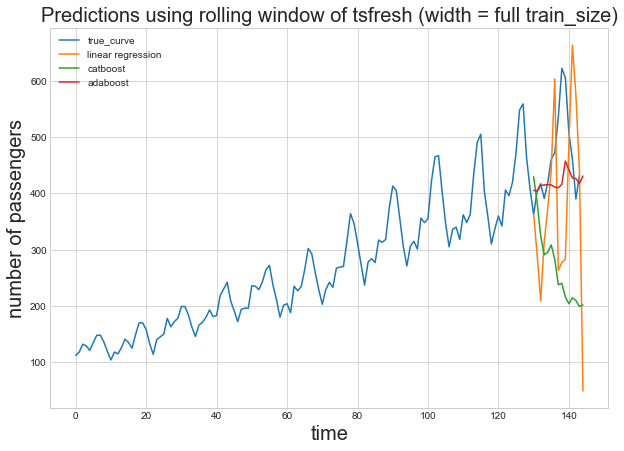

In [110]:
fig = plt.figure(figsize=(10, 7))

plt.plot(data, label = "true_curve")
plt.plot(data_test.index.values + 1, predictions_lr_new, label = "linear regression")
plt.plot(data_test.index.values + 1, predictions_cb_new, label = "catboost")
plt.plot(data_test.index.values + 1, predictions_ab_new, label = "adaboost")

plt.xlabel("time", size = 20)
plt.ylabel("number of passengers", size = 20)
plt.title("Predictions using rolling window of tsfresh (width = full train_size)", size = 20)
plt.legend()

plt.show()

In [113]:
predictions_lr_new

array([363.06132875, 290.61965875, 208.7831435 , 313.67489314,
       372.33964743, 442.06430671, 603.20663683, 263.16094512,
       276.97855755, 283.08267188, 487.39154106, 663.46523318,
       574.3538183 , 440.69607058,  48.85579646])

In [114]:
data_test.values

array([[407.],
       [362.],
       [405.],
       [417.],
       [391.],
       [419.],
       [461.],
       [472.],
       [535.],
       [622.],
       [606.],
       [508.],
       [461.],
       [390.],
       [432.]])

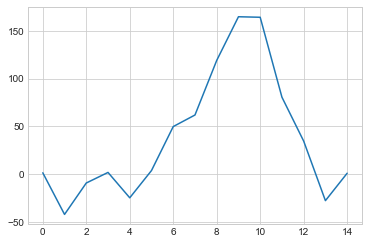

In [117]:
plt.plot(data_test.values.reshape(-1) - predictions_ab_new)

In [ ]:
change, только 